In [2]:
import numpy as np
import h5py
import torch
import os
import matplotlib.pyplot as plt

In [3]:
NUM_PLOTTED_CONDITIONS = 6
NUM_CLIENTS = 14
NUM_FOLDS = 5

In [ ]:
def load_final_model_performaces(cv_results_path, filename, type=None, h5_path=None, num_clients=14, num_folds=5, verbose=False):
    if h5_path is None:
        h5_path = os.path.join(cv_results_path, filename)
    if verbose:
        print(h5_path)
    
    # Load data from HDF5 file
    with h5py.File(h5_path, 'r') as f:
        a_group_key = list(f.keys())
        extraction_dict = dict()
        final_clients_loss_lst = []

        index = 0
        for key in a_group_key:
            extraction_dict[key] = f[key][()]
            if "client" in key:
                if isinstance(f[key][()], np.ndarray):
                    if len(extraction_dict[key])<2:
                        if verbose:
                            print(f"{index} {key}: len<2: appended -1 as placeholder!!!")
                        # This was a testing client and thus not trained...
                        final_clients_loss_lst.append(-1)
                        index += 1
                    else:
                        if verbose:
                            print(f"{index} {key}: ADDED!!!")
                        final_clients_loss_lst.append(f[key][()][-1])
                        index += 1
                else:
                    if verbose:
                        print(f"{key}: Not a numpy array!!!")
            else:
                if verbose:
                    print(f"{key}: Not a client log!!!")
    
    # Organize loss by client
    client_data_lst = [[] for _ in range(num_clients)]
    # Define the correct order mapping for the clients (client 0, 10, 11, 12, 13, 1, 2, ...)
    ## This is an artifact of the fact that the keys were strings and 10,11,etc comes before 1...
    correct_order = [0, 10, 11, 12, 13, 1, 2, 3, 4, 5, 6, 7, 8, 9]
    for trial_idx in range(num_folds):
        for client_idx in range(num_clients):
            # Use the correct client index mapping
            correct_client_idx = correct_order[client_idx]
            index = trial_idx * num_clients + client_idx
            client_data_lst[correct_client_idx].append(final_clients_loss_lst[index])
    
    if type=="CROSS":
        # Ensure that every client list has exactly one -1
        assert all(client_data.count(-1) == 1 for client_data in client_data_lst), "Some client lists do not have exactly one -1"

    # Remove all -1 values from each list
    cleaned_client_data_lst = [[x for x in sublist if x != -1] for sublist in client_data_lst]
    
    # Compute mean loss for each client
    client_final_loss_lst = [np.mean(np.array(cleaned_client_data_lst[client_idx])) for client_idx in range(num_clients)]
    
    if verbose:
        print("\n\n\n")
    
    return client_final_loss_lst

# Initial Sims Results Plot

In [6]:
results_path = r'C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\PythonVersion\PythonSimsRevamp\results'
current_directory = r'\Preliminary_Sims_Figure'
base_path = results_path + current_directory

# CROSS
cross_pfa = load_final_model_performaces(base_path+r'\08-21_18-08_PFAFO_GDLS', 'GDLS_PFAFO_GDLS_CrossValResults.h5')#, type="CROSS")
cross_fedavg = load_final_model_performaces(base_path+r'\08-21_18-07_FEDAVG', 'GDLS_FEDAVG_CrossValResults.h5')#, type="CROSS")
cross_nofl = load_final_model_performaces(base_path+r'\08-21_16-24_NOFL', 'FULLSCIPYMIN_NOFL_CrossValResults.h5')#, type="CROSS")
#load_final_model_performaces(r'', filename)
# INTRA
intra_nofl = load_final_model_performaces(base_path+r'\08-21_22-02_NOFL', 'FULLSCIPYMIN_NOFL_CrossValResults.h5', type="INTRA")
intra_fedavg = load_final_model_performaces(base_path+r'\08-21_22-06_FEDAVG', 'GDLS_FEDAVG_CrossValResults.h5', type="INTRA")
intra_pfa1 = load_final_model_performaces(base_path+r'\08-21_22-07_PFAFO_GDLS', 'GDLS_PFAFO_GDLS_CrossValResults.h5', type="INTRA")
intra_pfa2 = load_final_model_performaces(base_path+r'\08-21_22-09_PFAFO_GDLS', 'GDLS_PFAFO_GDLS_CrossValResults.h5', type="INTRA")


In [7]:
print("VERIFYING LOADED IN DATA IS DIFFERENT")
print(f"intra_nofl sum: {np.sum(intra_nofl)}")
print(f"cross_nofl sum: {np.sum(cross_nofl)}")
print()
print(f"intra_fedavg sum: {np.sum(intra_fedavg)}")
print(f"cross_fedavg sum: {np.sum(cross_fedavg)}")
print()
print(f"intra_pfa1 sum: {np.sum(intra_pfa1)}")
print(f"intra_pfa2 sum: {np.sum(intra_pfa2)}")
print(f"cross_pfa sum: {np.sum(cross_pfa)}")


VERIFYING LOADED IN DATA IS DIFFERENT
intra_nofl sum: 2.6605898383851655e-06
cross_nofl sum: 2.6605898383851655e-06

intra_fedavg sum: 7.065237808365493e-05
cross_fedavg sum: 7.065237808365493e-05

intra_pfa1 sum: 9.438317479935952e-05
intra_pfa2 sum: 5.149926416575894e-06
cross_pfa sum: 9.438317479935952e-05


... why is the data from different files the same... ............ ....
- Pretty sure the curves weren't the same...

In [8]:
all_trials_lst = [intra_nofl, intra_fedavg, intra_pfa1, cross_nofl, cross_fedavg, cross_pfa]

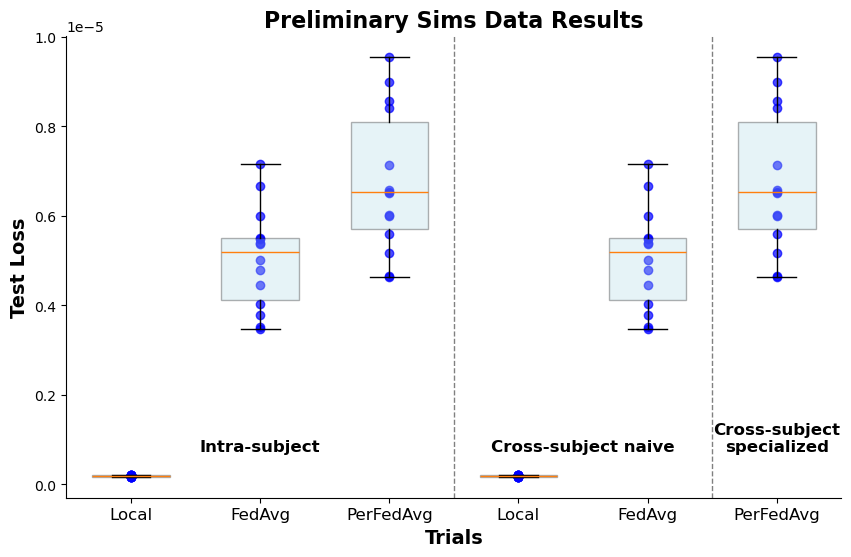

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Set up the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Define x-tick labels and corresponding subgroup labels
x_labels = ['Local', 'FedAvg', 'PerFedAvg', 'Local', 'FedAvg', 'PerFedAvg']
subgroup_labels = ['Intra-subject', 'Cross-subject naive', 'Cross-subject\nspecialized']

# Positions for the boxplots
positions = np.arange(len(x_labels))

# Plotting the boxplots with transparent boxes
boxplot_elements = ax.boxplot(all_trials_lst, positions=positions, widths=0.6, patch_artist=True)

# Set the transparency for the boxes
for box in boxplot_elements['boxes']:
    box.set_facecolor('lightblue')  # Set box color
    box.set_alpha(0.3)  # Set transparency (0: fully transparent, 1: fully opaque)

# Plotting the scatter points over the boxplots
for i in range(NUM_PLOTTED_CONDITIONS):
    # Scatter plot of points for each trial
    ax.scatter([i]*NUM_CLIENTS, all_trials_lst[i], alpha=0.7, color='blue')

# Set the x-tick labels
ax.set_xticks(positions)
ax.set_xticklabels(x_labels, fontsize=12)

# Adding vertical lines for separation
ax.axvline(x=2.5, color='gray', linestyle='--', linewidth=1)
ax.axvline(x=4.5, color='gray', linestyle='--', linewidth=1)

# Get axis limits and adjust text positioning accordingly
ax = plt.gca()  # Get current axis
ylim = ax.get_ylim()  # Get y-axis limits
# Place text closer to the x-axis based on ylim
y_position = ylim[0] + 0.1 * (ylim[1] - ylim[0])  # Adjust the position just below the x-axis
# Adding subgroup labels below the x-tick labels with better positioning
ax.text(1, y_position, 'Intra-subject', ha='center', fontsize=12, weight='bold')
ax.text(3.5, y_position, 'Cross-subject naive', ha='center', fontsize=12, weight='bold')
ax.text(5, y_position, 'Cross-subject\nspecialized', ha='center', fontsize=12, weight='bold')

# Axis labels
ax.set_ylabel("Test Loss", fontsize=14, fontweight='bold')
ax.set_xlabel("Trials", fontsize=14, fontweight='bold')
ax.set_title("Preliminary Sims Data Results", fontsize=16, fontweight='bold')

# Customizing fonts globally (optional, can be changed)
plt.rcParams.update({
    'font.family': 'serif',  # Choose a serif font
    'font.serif': ['Times New Roman'],  # Set to Times New Roman (if available)
    'font.size': 14,  # Adjust default font size
    'axes.titlesize': 16,  # Title font size
    'axes.labelsize': 14,  # Label font size
    'legend.fontsize': 12,  # Legend font size
})

# Remove top and right plot borders
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(False)

# Tight layout for better spacing
#plt.tight_layout()

# Show the plot
plt.show()


# Updated Version
- Needed to make a ton of code changes for some reason (mainly to the loading function and how data was saved)
- Other (main, actually) goal was to increase number of training rounds for FL approaches to make them more on par with Local (however, they plateua early and stop improving after that...)

In [10]:
results_path = r'C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\PythonVersion\PythonSimsRevamp\results'
current_directory = r'\Prelim_Sim_Results_V2'
base_path = results_path + current_directory

# CROSS
cross_pfa = load_final_model_performaces(base_path+r'\08-23_21-20_PFAFO_GDLS', 'GDLS_PFAFO_GDLS_CrossValResults.h5', type="CROSS")
cross_fedavg = load_final_model_performaces(base_path+r'\08-23_22-17_FEDAVG', 'GDLS_FEDAVG_CrossValResults.h5', type="CROSS")
cross_nofl = load_final_model_performaces(base_path+r'\08-23_22-18_NOFL', 'FULLSCIPYMIN_NOFL_CrossValResults.h5', type="CROSS")
#load_final_model_performaces(r'', filename)
# INTRA
intra_nofl = load_final_model_performaces(base_path+r'\08-23_20-43_NOFL_INTRA', 'FULLSCIPYMIN_NOFL_CrossValResults.h5', type="INTRA")
intra_fedavg = load_final_model_performaces(base_path+r'\08-23_20-42_FEDAVG_INTRA', 'GDLS_FEDAVG_CrossValResults.h5', type="INTRA")
intra_pfa1 = load_final_model_performaces(base_path+r'\08-23_18-56_PFAFO_GDLS_INTRA', 'GDLS_PFAFO_GDLS_CrossValResults.h5', type="INTRA")


In [11]:
print("VERIFYING LOADED IN DATA IS DIFFERENT")
print(f"intra_nofl sum: {np.sum(intra_nofl)}")
print(f"cross_nofl sum: {np.sum(cross_nofl)}")
print()
print(f"intra_fedavg sum: {np.sum(intra_fedavg)}")
print(f"cross_fedavg sum: {np.sum(cross_fedavg)}")
print()
print(f"intra_pfa1 sum: {np.sum(intra_pfa1)}")
#print(f"intra_pfa2 sum: {np.sum(intra_pfa2)}")
print(f"cross_pfa sum: {np.sum(cross_pfa)}")


VERIFYING LOADED IN DATA IS DIFFERENT
intra_nofl sum: 2.661179559350635e-06
cross_nofl sum: 0.02537912432752478

intra_fedavg sum: 2.6653245942105556e-06
cross_fedavg sum: 0.02532452044982489

intra_pfa1 sum: 2.6852644528306384e-06
cross_pfa sum: 0.02531736317628302


In [12]:
all_trials_lst = [intra_nofl, intra_fedavg, intra_pfa1, cross_nofl, cross_fedavg, cross_pfa]

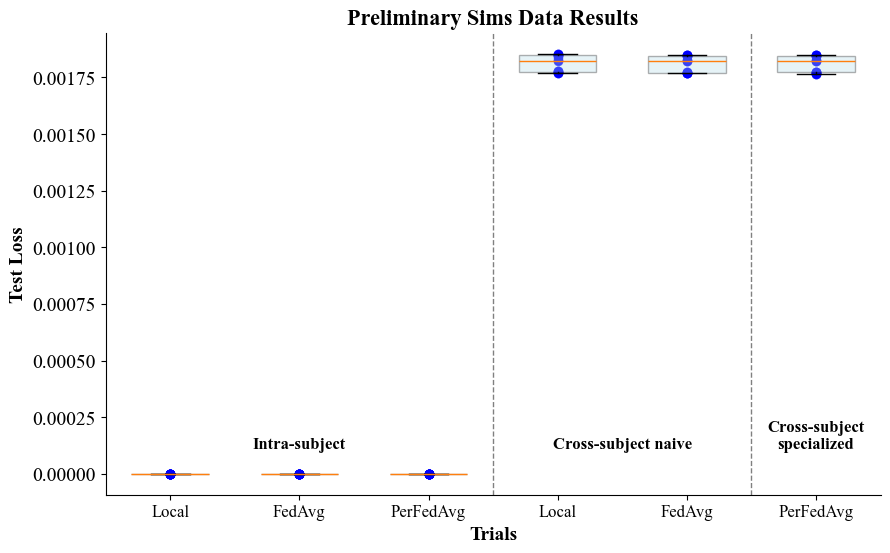

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Set up the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Define x-tick labels and corresponding subgroup labels
x_labels = ['Local', 'FedAvg', 'PerFedAvg', 'Local', 'FedAvg', 'PerFedAvg']
subgroup_labels = ['Intra-subject', 'Cross-subject naive', 'Cross-subject\nspecialized']

# Positions for the boxplots
positions = np.arange(len(x_labels))

# Plotting the boxplots with transparent boxes
boxplot_elements = ax.boxplot(all_trials_lst, positions=positions, widths=0.6, patch_artist=True)

# Set the transparency for the boxes
for box in boxplot_elements['boxes']:
    box.set_facecolor('lightblue')  # Set box color
    box.set_alpha(0.3)  # Set transparency (0: fully transparent, 1: fully opaque)

# Plotting the scatter points over the boxplots
for i in range(NUM_PLOTTED_CONDITIONS):
    # Scatter plot of points for each trial
    ax.scatter([i]*NUM_CLIENTS, all_trials_lst[i], alpha=0.7, color='blue')

# Set the x-tick labels
ax.set_xticks(positions)
ax.set_xticklabels(x_labels, fontsize=12)

# Adding vertical lines for separation
ax.axvline(x=2.5, color='gray', linestyle='--', linewidth=1)
ax.axvline(x=4.5, color='gray', linestyle='--', linewidth=1)

# Get axis limits and adjust text positioning accordingly
ax = plt.gca()  # Get current axis
ylim = ax.get_ylim()  # Get y-axis limits
# Place text closer to the x-axis based on ylim
y_position = ylim[0] + 0.1 * (ylim[1] - ylim[0])  # Adjust the position just below the x-axis
# Adding subgroup labels below the x-tick labels with better positioning
ax.text(1, y_position, 'Intra-subject', ha='center', fontsize=12, weight='bold')
ax.text(3.5, y_position, 'Cross-subject naive', ha='center', fontsize=12, weight='bold')
ax.text(5, y_position, 'Cross-subject\nspecialized', ha='center', fontsize=12, weight='bold')


# Axis labels
ax.set_ylabel("Test Loss", fontsize=14, fontweight='bold')
ax.set_xlabel("Trials", fontsize=14, fontweight='bold')
ax.set_title("Preliminary Sims Data Results", fontsize=16, fontweight='bold')

# Customizing fonts globally (optional, can be changed)
plt.rcParams.update({
    'font.family': 'serif',  # Choose a serif font
    'font.serif': ['Times New Roman'],  # Set to Times New Roman (if available)
    'font.size': 14,  # Adjust default font size
    'axes.titlesize': 16,  # Title font size
    'axes.labelsize': 14,  # Label font size
    'legend.fontsize': 12,  # Legend font size
})

# Remove top and right plot borders
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(False)

# Tight layout for better spacing
#plt.tight_layout()

# Show the plot
plt.show()


In [30]:
INTRA_YLIM_UPPERBOUND = 0.3e-6
CROSS_YLIM_LOWERBOUND = 0.0015
CROSS_YLIM_UPPERBOUND = 0.002

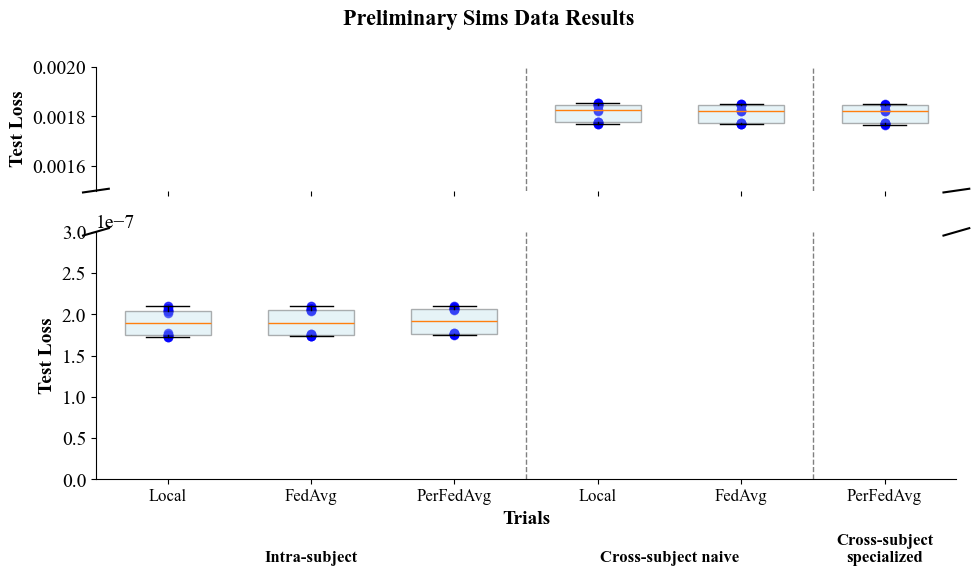

In [31]:


# Set up the figure and two subplots, sharing the x-axis
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 6), gridspec_kw={'height_ratios': [1, 2]})

# Define x-tick labels and corresponding subgroup labels
x_labels = ['Local', 'FedAvg', 'PerFedAvg', 'Local', 'FedAvg', 'PerFedAvg']
subgroup_labels = ['Intra-subject', 'Cross-subject naive', 'Cross-subject\nspecialized']

# Positions for the boxplots
positions = np.arange(len(x_labels))

# Plotting the boxplots for ax1 and ax2 with transparent boxes
boxplot_elements1 = ax1.boxplot(all_trials_lst, positions=positions, widths=0.6, patch_artist=True)
boxplot_elements2 = ax2.boxplot(all_trials_lst, positions=positions, widths=0.6, patch_artist=True)

# Set the transparency for the boxes in both subplots
for box in boxplot_elements1['boxes'] + boxplot_elements2['boxes']:
    box.set_facecolor('lightblue')  # Set box color
    box.set_alpha(0.3)  # Set transparency (0: fully transparent, 1: fully opaque)

# Plotting the scatter points over the boxplots in both subplots
for i in range(NUM_PLOTTED_CONDITIONS):
    ax1.scatter([i] * NUM_CLIENTS, all_trials_lst[i], alpha=0.7, color='blue')
    ax2.scatter([i] * NUM_CLIENTS, all_trials_lst[i], alpha=0.7, color='blue')

# Set y-limits for each subplot to create the break
ax1.set_ylim(CROSS_YLIM_LOWERBOUND, CROSS_YLIM_UPPERBOUND)  # High values for CROSS-subject
ax2.set_ylim(0, INTRA_YLIM_UPPERBOUND)  # Low values for INTRA-subject

# Adding the "break" visual indicators
ax1.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax1.tick_params(labeltop=False)  # Don't show top labels
ax2.xaxis.tick_bottom()  # Only show x labels on the bottom plot

# Diagonal lines indicating the break
d = 0.015  # Size of diagonal lines
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((-d, +d), (-d, +d), **kwargs)  # Top-left diagonal
ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # Top-right diagonal

kwargs.update(transform=ax2.transAxes)
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # Bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # Bottom-right diagonal

# Set the x-tick labels for the bottom plot
ax2.set_xticks(positions)
ax2.set_xticklabels(x_labels, fontsize=12)

# Adding vertical lines for separation in both subplots
for ax in [ax1, ax2]:
    ax.axvline(x=2.5, color='gray', linestyle='--', linewidth=1)
    ax.axvline(x=4.5, color='gray', linestyle='--', linewidth=1)

# Adding subgroup labels below the x-tick labels with better positioning in the bottom plot
ax2.text(1, -1e-7, 'Intra-subject', ha='center', fontsize=12, weight='bold')
ax2.text(3.5, -1e-7, 'Cross-subject naive', ha='center', fontsize=12, weight='bold')
ax2.text(5, -1e-7, 'Cross-subject\nspecialized', ha='center', fontsize=12, weight='bold')

# Axis labels and title
ax1.set_ylabel("Test Loss", fontsize=14, fontweight='bold')
ax2.set_ylabel("Test Loss", fontsize=14, fontweight='bold')
ax2.set_xlabel("Trials", fontsize=14, fontweight='bold')
fig.suptitle("Preliminary Sims Data Results", fontsize=16, fontweight='bold')

# Remove top and right plot borders from both subplots
for ax in [ax1, ax2]:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(False)

# Tight layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()


In [ ]:
assert(False)

In [ ]:
import numpy as np

# Ground truth (actual) and predicted values
y_true = np.array([...])  # Ground truth values
y_pred = np.array([...])  # Predicted values

# Calculate the residual sum of squares
ss_res = np.sum((y_true - y_pred) ** 2)

# Calculate the total sum of squares
ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)

# Calculate R^2
r_squared = 1 - (ss_res / ss_tot)

print(f"R^2: {r_squared}")
